# Pruning Methods for Decision Tree
 - Decision trees are often prone to overfitting.
 - To avoid or to correct this problem we use pruning techniques.

In [3]:
# Importing Basic Libraries
import pandas as pd # for Data manipulation
import matplotlib.pyplot as plt # for visualization
import seaborn as sns # for visualization
import numpy as np # to provide equidistance interval for finding alpha
from sklearn import tree as tr # For tree visualization


# Importing the Dataset
iris=pd.read_csv("iris.csv")
iris=iris.loc[:,['SepalLengthCm','SepalWidthCm','Species']] # Selecting only three columns for easier calculations
iris.head()

,SepalLengthCm,SepalWidthCm,Species
0,5.1,3.5,Iris-setosa
1,4.9,3.0,Iris-setosa
2,4.7,3.2,Iris-setosa
3,4.6,3.1,Iris-setosa
4,5.0,3.6,Iris-setosa


In [4]:
X=iris.drop(columns="Species")
y=iris["Species"]

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.20,random_state=45)

In [5]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=40)
tree.fit(X_train,y_train)
y_train_pred=tree.predict(X_train)
y_test_pred=tree.predict(X_test)

In [6]:
tree.get_depth()

10

In [7]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_train,y_train_pred),round(accuracy_score(y_test,y_test_pred),2))

0.95 0.63


Here the train accuracy is 95% and test accuracy is 63%. So the model is overfitting.<br>
Hence to avoid this we will do pre pruning and to correct it we will do post pruning.

## Pre-Pruning
In this method we use GridSearchCV to determine the best values of parameters to train the model.

In [6]:
from sklearn.model_selection import GridSearchCV
grid_param={"criterion":["gini","entropy"],
             "splitter":["best","random"],
             "max_depth":range(2,50,1),
             "min_samples_leaf":range(1,15,1),
             "min_samples_split":range(2,20,1) 
            }
grid_search=GridSearchCV(estimator=tree,param_grid=grid_param,cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=40), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 50),
                         'min_samples_leaf': range(1, 15),
                         'min_samples_split': range(2, 20),
                         'splitter': ['best', 'random']})

In [7]:
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}


We found the best parameter. Now we will use these parameters to get a generalised solution.

In [8]:
tree_pre = DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, min_samples_leaf= 1,
                              min_samples_split= 6, splitter= 'random',random_state=40)
tree_pre.fit(X_train,y_train)
y_train_pred=tree_pre.predict(X_train)
y_test_pred=tree_pre.predict(X_test)

print(accuracy_score(y_train,y_train_pred),accuracy_score(y_test,y_test_pred))

0.775 0.7666666666666667


Here we can see the Train and test accuracy are nearly equal. Hence now our model will predict well.

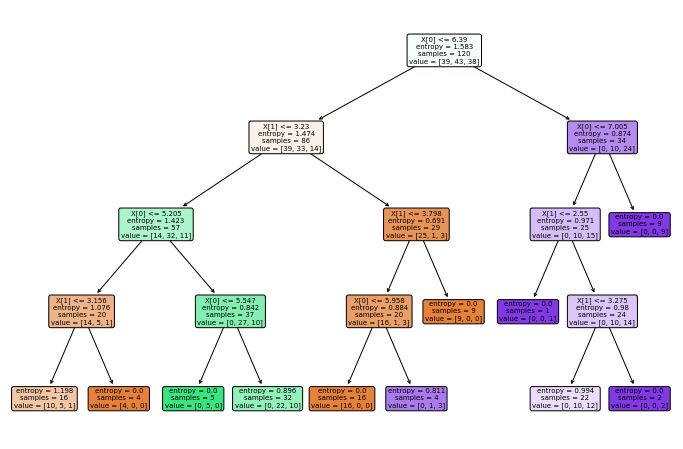

In [9]:
plt.figure(figsize=(12,8))
tr.plot_tree(tree_pre,rounded=True,filled=True)
plt.show()

## Post-Pruning
 - In this method we will use the cc_alpha parameter to get the cost complexity parameter($\alpha $)
 - We will use this parameter to train our model
 - Greater values of ccp_alpha increase the number of nodes pruned.

In [10]:
path=tree.cost_complexity_pruning_path(X_train,y_train)
alphas=path['ccp_alphas']

alphas

array([0.        , 0.00277778, 0.00277778, 0.00277778, 0.00324074,
       0.00518519, 0.00555556, 0.00694444, 0.00743464, 0.01006944,
       0.01041667, 0.01161038, 0.01230159, 0.01581699, 0.02010944,
       0.05683866, 0.06089286, 0.20756944])

In [11]:
len(alphas)

18

In [12]:
alphas.min(),alphas.max()

(0.0, 0.2075694444444443)

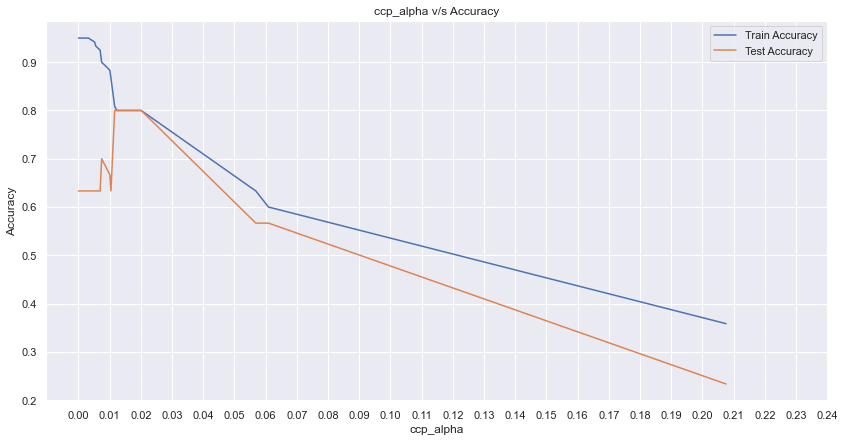

In [15]:
accuracy_train,accuracy_test=[],[]

for i in alphas:
    tree=DecisionTreeClassifier(ccp_alpha=i)
    
    tree.fit(X_train,y_train)
    y_train_pred=tree.predict(X_train)
    y_test_pred=tree.predict(X_test)
    
    accuracy_train.append(accuracy_score(y_train,y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    
    
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=accuracy_train,x=alphas,label="Train Accuracy")
sns.lineplot(y=accuracy_test,x=alphas,label="Test Accuracy")
plt.xticks(ticks=np.arange(0.00,0.25,0.01))
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')
plt.title('ccp_alpha v/s Accuracy')
plt.show()

From this we take the $\alpha $ value as 0.02 as we have max accuracy for test at this point. <br>
We will use this as a parameter to fit the model

In [13]:
tree_post = DecisionTreeClassifier(ccp_alpha=0.02,random_state=40)
tree_post.fit(X_train,y_train)
y_train_pred=tree_post.predict(X_train)
y_test_pred=tree_post.predict(X_test)

print(accuracy_score(y_train,y_train_pred),accuracy_score(y_test,y_test_pred))

0.8 0.8


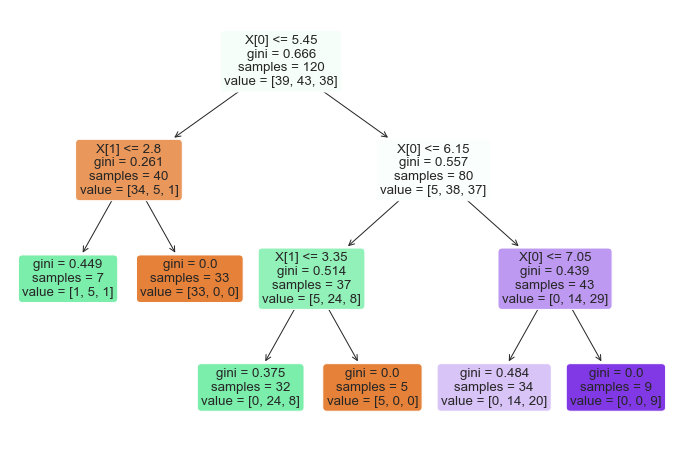

In [17]:
plt.figure(figsize=(12,8))
tr.plot_tree(tree_post,rounded=True,filled=True)
plt.show()

So we can see we get better accuracy using **Post pruning techniques**

###### Advantages of Pre-Pruning over Post-Pruning
 - Pre-pruning is faster in operation that post pruning. This is especially important on larger datasets in which we may have more number of features or more records.
 - Pre-pruning can sometimes attain similar or even better results than post-pruning.<br>
 
###### Advantages of Post-Pruning over Pre-Pruning
 - Post-pruning usually results in a better tree than pre-pruning because pre-pruning is greedy and may ignore splits that have subsequently important splits.
